<a href="https://colab.research.google.com/github/NelsenTimoty/colab_projects/blob/main/speech_recog_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import all the necessary libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbs
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, log_loss, classification_report, accuracy_score,  roc_auc_score, roc_curve, auc
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

**Importing The Data**

In [ ]:
df_fake = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")
df_fake['Label']='Fake'
df_true['Label']='True'
df_fake.shape, df_true.shape

((23481, 5), (21417, 5))

**Observation:**

*Here we observe that nearly all of the true texts contain the word "Reuters". This presence may lead to overfitting during model training. Hence, we will need to remove it during the data preprocessing stage.*

In [ ]:
j=0
for i in df_true['text']:
    if '(Reuters)' in i:
        j+=1
j

21247

**Manual Testing Dataset**

In [ ]:
df_manual=pd.DataFrame()
df_manual['title']=''
df_manual['text']=''
df_manual['subject']=''
df_manual['date']=''
df_manual['Label']=''


for i in range(516,526):
    df_manual.loc[len(df_manual)]= df_fake.loc[i]
    df_fake.drop(index=i, inplace=True, axis='index')
for i in range(487,498):
    df_manual.loc[len(df_manual)]= df_true.loc[i]
    df_true.drop(index=i, inplace=True, axis='index')
df_fake.shape, df_true.shape

((23471, 5), (21406, 5))

**Combining The Dataset**

In [ ]:
df_train= pd.concat([df_fake, df_true], axis=0)
df_train

,title,text,subject,date,Label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Fake
...,...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",True
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",True
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",True
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",True


In [ ]:
df_train=df_train.sample(frac=0.5)

**Preprocessing Data**

In [ ]:
df_train.shape

(22438, 5)

In [ ]:
df_train.describe()

,title,text,subject,date,Label
count,22438,22438,22438,22438,22438
unique,20779,20599,8,2353,2
top,Factbox: International reaction to arrest of R...,,politicsNews,"December 20, 2017",Fake
freq,6,315,5575,97,11703


In [ ]:
df_train.head(5)

,title,text,subject,date,Label
21073,MUSLIM REFUGEES DUMP GARBAGE In Streets To Pro...,"Complaints over lack of wi-fi, no professional...",left-news,"Jan 24, 2016",Fake
14520,Five Kenyans killed by mobs for looting in opp...,NAIROBI (Reuters) - Kenya s police service sai...,worldnews,"November 17, 2017",True
3004,Republican Lawmaker Grabs Woman By The Genita...,Conservatives are now committing sexual assaul...,News,"January 15, 2017",Fake
3423,Scientists Scramble To Copy Climate Data Befo...,Donald Trump isn t exactly a stickler for fact...,News,"December 13, 2016",Fake
11686,Ugandan parliament passes law allowing Museven...,KAMPALA (Reuters) - Ugandan legislators voted ...,worldnews,"December 20, 2017",True


In [ ]:
df_train.fillna('', inplace=True)
df_train.isna().sum()

title      0
text       0
subject    0
date       0
Label      0
dtype: int64

In [ ]:
df_train.drop_duplicates(inplace=True)
df_train.duplicated().sum()

0

In [ ]:
df_train.reset_index(inplace=True)
df_train

,index,title,text,subject,date,Label
0,21073,MUSLIM REFUGEES DUMP GARBAGE In Streets To Pro...,"Complaints over lack of wi-fi, no professional...",left-news,"Jan 24, 2016",Fake
1,14520,Five Kenyans killed by mobs for looting in opp...,NAIROBI (Reuters) - Kenya s police service sai...,worldnews,"November 17, 2017",True
2,3004,Republican Lawmaker Grabs Woman By The Genita...,Conservatives are now committing sexual assaul...,News,"January 15, 2017",Fake
3,3423,Scientists Scramble To Copy Climate Data Befo...,Donald Trump isn t exactly a stickler for fact...,News,"December 13, 2016",Fake
4,11686,Ugandan parliament passes law allowing Museven...,KAMPALA (Reuters) - Ugandan legislators voted ...,worldnews,"December 20, 2017",True
...,...,...,...,...,...,...
22372,12121,DESTROYED IN 10 SECONDS: Tucker Carlson EXPOSE...,Tucker goes on to call out the hypocrisy of ri...,politics,"Dec 17, 2016",Fake
22373,18318,WATCH: JESSE JACKSON Mumbles HILARIOUS Reason ...,Civil Rights activist Rev. Jesse Jackson Sr. a...,left-news,"Jul 14, 2017",Fake
22374,22725,"Meredith Corp. and Koch Money Buys Time Inc., ...",21st Century Wire says News broke Sunday night...,Middle-east,"November 27, 2017",Fake
22375,16307,Czech election winner Babis warms to minority ...,PRAGUE (Reuters) - The anti-establishment ANO ...,worldnews,"October 27, 2017",True


**Code to Remove the word "Reuter"**

In [ ]:
def reuters_removal(text):
    reuters_text=''
    reuters_text= text.split()
    reuters_text= [word for word in reuters_text if not word=="(Reuters)"]
    reuters_text= [word for word in reuters_text if not word=="Reuters"]
    reuters_text= " ".join(reuters_text)
    return reuters_text
df_train['text']=df_train['text'].apply(reuters_removal)

In [ ]:
j=0
for i in df_train.loc[df_train['Label']=="True", 'text']:
    if '(Reuters)' in i:
        j+=1

j

4

**Data Visualization**

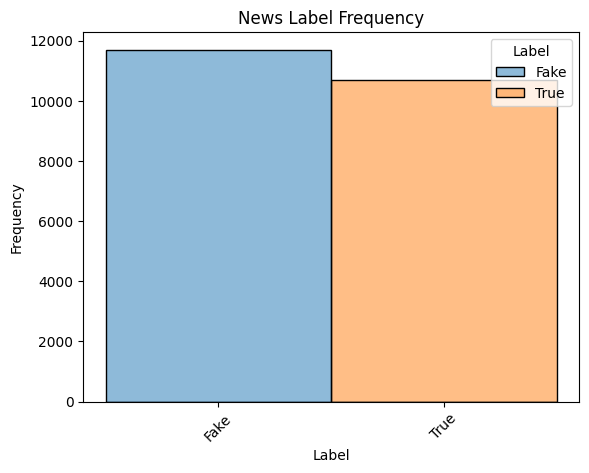

In [ ]:
sbs.histplot(x='Label', hue='Label',data=df_train)
plt.title('News Label Frequency')
plt.xticks(rotation=45)
plt.ylabel('Frequency');

In [ ]:
df_top=df_train.copy()
df_top_group=df_top.subject.value_counts()
df_top_group

subject
politicsNews       5564
worldnews          5111
News               4447
politics           3428
left-news          2277
Government News     771
US_News             394
Middle-east         385
Name: count, dtype: int64

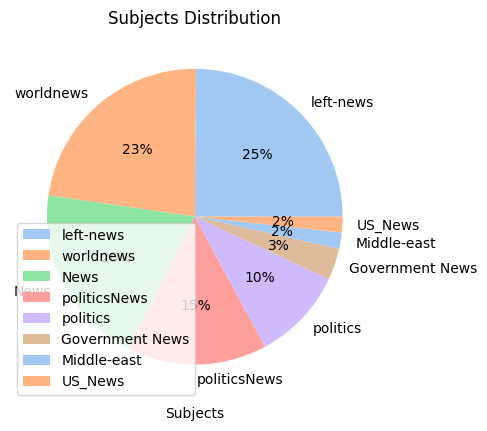

In [ ]:
colors = sbs.color_palette('pastel')[0:6]
plt.pie(df_top_group,labels=df_top.subject.unique(),autopct='%.0f%%', colors=colors)
plt.title('Subjects Distribution')
plt.xlabel('Subjects')
plt.legend(df_top.subject.unique(), loc='lower left')
plt.show();

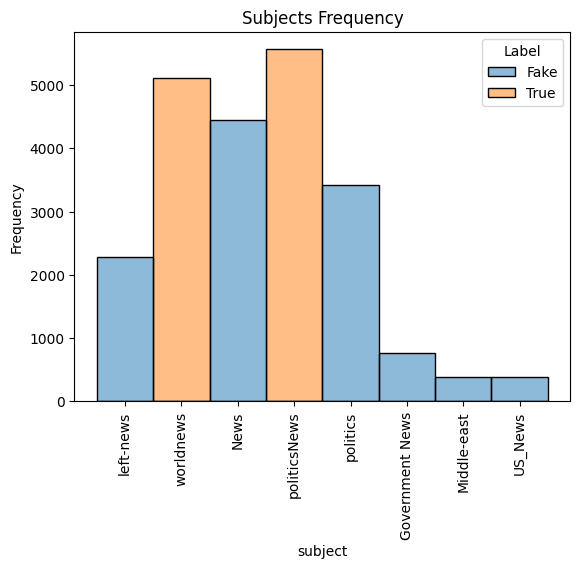

In [ ]:
top_parties = df_train['subject'].value_counts().nlargest(5).index
df_top=df_train.copy()
df_top.loc[~df_top['subject'].isin(top_parties), 'Party'] = 'Other'
sbs.histplot(x='subject', hue='Label', data=df_top, stat='count')
plt.title('Subjects Frequency')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.show();

In [ ]:
df_train.loc[df_train['subject']=="politicsNews","Label"].unique()

array(['True'], dtype=object)

**Splitting The Data**

*We will split the dataset into training and testing sets. Additionally, we will encode the labels into numerical values to facilitate the calculation of the reliability percentage of the news articles.*

In [ ]:
y= df_train['Label']
X=df_train.drop(['Label', "date",'index'], axis=1)
y.unique()

array(['Fake', 'True'], dtype=object)

In [ ]:
X

,title,text,subject
0,MUSLIM REFUGEES DUMP GARBAGE In Streets To Pro...,"Complaints over lack of wi-fi, no professional...",left-news
1,Five Kenyans killed by mobs for looting in opp...,NAIROBI - Kenya s police service said five peo...,worldnews
2,Republican Lawmaker Grabs Woman By The Genita...,Conservatives are now committing sexual assaul...,News
3,Scientists Scramble To Copy Climate Data Befo...,Donald Trump isn t exactly a stickler for fact...,News
4,Ugandan parliament passes law allowing Museven...,KAMPALA - Ugandan legislators voted overwhelmi...,worldnews
...,...,...,...
22372,DESTROYED IN 10 SECONDS: Tucker Carlson EXPOSE...,Tucker goes on to call out the hypocrisy of ri...,politics
22373,WATCH: JESSE JACKSON Mumbles HILARIOUS Reason ...,Civil Rights activist Rev. Jesse Jackson Sr. a...,left-news
22374,"Meredith Corp. and Koch Money Buys Time Inc., ...",21st Century Wire says News broke Sunday night...,Middle-east
22375,Czech election winner Babis warms to minority ...,PRAGUE - The anti-establishment ANO party that...,worldnews


**Stemming and Stop Words**

In [ ]:
port_stemmer= PorterStemmer()
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
def stemmer(text):
    # Process the text
    doc = nlp(text)

    # Extract the lemma of each token if it is not a stopword or punctuation
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
X['text']= X['text'].apply(stemmer)
X=X['text']
X

0        complaint lack wi fi professional cleaning ser...
1        NAIROBI Kenya s police service say people kill...
2        conservative commit sexual assault embolden Do...
3        Donald Trump isn t exactly stickler fact clear...
4        KAMPALA Ugandan legislator vote overwhelmingly...
                               ...                        
22372    Tucker go hypocrisy rich liberal elitist actor...
22373    Civil Rights activist Rev. Jesse Jackson Sr at...
22374    21st Century Wire say News break Sunday night ...
22375    PRAGUE anti establishment ANO party win Czech ...
22376    maybe Hillary hire handle social medium hey ma...
Name: text, Length: 22377, dtype: object

**Train Test Split**

In [ ]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.2, random_state=40, stratify=y)

**TF-IDF Vectorization**

*TF-IDF (Term Frequency-Inverse Document Frequency) is a technique used to represent text data numerically*

In [ ]:
vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(X_train)
xv_test = vectorization.transform(X_test)

**Model Training Using Logistic Regression**

In [ ]:
lgr=LogisticRegression(max_iter=1000)
lgr.fit(xv_train,y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred=lgr.predict(xv_test)
acc = accuracy_score(y_pred,y_test)
print("Accuracy: ", round(acc*100,1 ), "%")
print(classification_report(y_test, y_pred))

Accuracy:  97.5 %
              precision    recall  f1-score   support

        Fake       0.98      0.97      0.98      2341
        True       0.97      0.98      0.97      2135

    accuracy                           0.98      4476
   macro avg       0.98      0.98      0.98      4476
weighted avg       0.98      0.98      0.98      4476



**Testing**

In [ ]:
def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(reuters_removal)

    new_def_test["text"] = new_def_test["text"].apply(stemmer)
    new_x_test = new_def_test["text"]
    new_xv_test = vectorization.transform(new_x_test)
    prediction= lgr.predict(new_xv_test)
    return prediction[0]
manual_testing(df_manual.loc[12,'text'])

In [ ]:
df_manual